In [1]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter,prep_ttbar

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib


# Goal: Develop embedding based on sim energy

In [2]:
n = 80

arr = torch.load('TTBAR/ttbar_1_greater_1_sim')
if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'TTBAR/ttbar_{int(n+2)}_greater_1_sim')])


In [213]:
tarr = arr[0:10000]

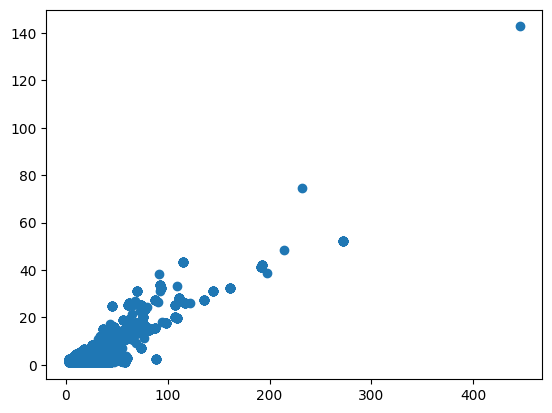

In [214]:
plt.scatter(torch.mean(tarr,dim=1),tarr[:,-5])

In [317]:
arr[0]

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   6.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   8.0000,   0.0000,   0.0000,  46.0000,  14.0000,
          0.0000,   0.0000, 423.0000, 170.0000,   0.0000,   0.0000,  89.0000,
         -1.0000,   9.0000,  10.0000,   5.0000,   2.3575,   2.0000,   1.0000,
          1.5735,   2.6140], dtype=torch.float64)

In [331]:
sum_dt = torch.sum(arr[:,0:48],dim=1)
std = torch.std(sum_dt)
mean = torch.mean(sum_dt)
labels = (sum_dt-mean)/std
adj_labels = []

for l in labels:
    if l.item() < 2: 
        adj_labels.append(0)
    else:
        adj_labels.append(1)
adj_labels = torch.tensor(adj_labels)

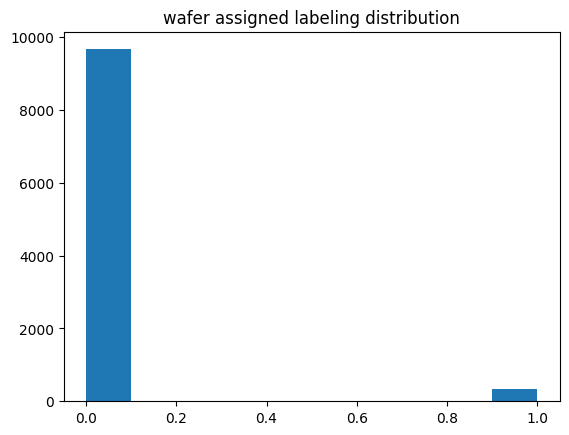

In [334]:
plt.title('wafer assigned labeling distribution')
plt.hist(adj_labels[0:10000])
plt.show()

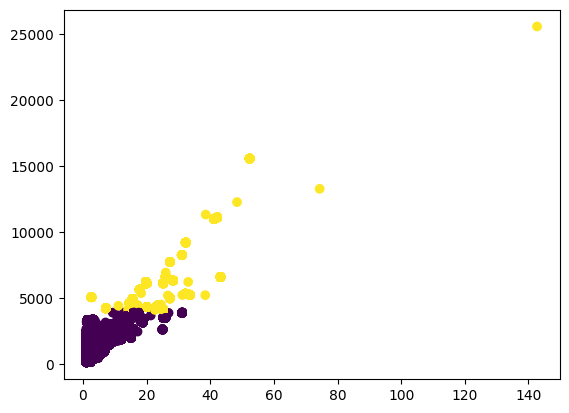

In [333]:
plt.scatter(arr[:,-5],torch.sum(arr[:,0:48],dim=1),c =adj_labels )

In [336]:
labeled_arr = torch.hstack([arr[0:10000,0:48],torch.unsqueeze(adj_lab[0:10000],dim=1)])

In [339]:
labeled_arr[:,0:48] = (labeled_arr[:,0:48] - torch.mean(labeled_arr[:,0:48]))/torch.std(labeled_arr[:,0:48])


In [201]:
# want to pull similar sim_energy to be close together
# want to push apart other sim energies

def embedding_loss(data):
    loss = torch.tensor(0.0).requires_grad_()
    for i in range(len(data)):
        main = data[i]
        for j in range(len(data)):
            if i != j: 
                cur = data[j]
                d = torch.norm(main[0]-cur[0])
                sim_dif_p = torch.abs(main[1]-cur[1])/main[1]
                if sim_dif_p < 0.05:
                    avg_sim = torch.add(cur[-5], main[-5])/2
                    loss = torch.add(loss,np.log(d*avg_sim))
                elif sim_dif_p > 0.2:
                    avg_sim = torch.add(cur[-5],main[-5])/2
                    loss = torch.add(loss,np.log(d/avg_sim))
    return loss